# Calibration and Correction of State Preparation and Measurement (SPAM)

Quantum Computers available in the NISQ-era are limited by significant sources of device noise which cause errors in computation. One such noise source is errors in the preparation and measurement of quantum states, more commonly know as SPAM. <br>

If device SPAM error can be characterised, then device results can be modified to mitigate the error. Characterisation proceeds by determining overlap between different prepared basis states when measured, and mitigation modifies the distribution over output states of the corrected circuit. No modification of the quantum circuit being corrected is required. The ``` pytket```  ```SpamCorrecter```  class supports characterisation and mitigation of device SPAM error. <br>

In this tutorial we will show how the ```SpamCorrecter```  class can be used to modify real results and improve device performance when running experiments. <br>

This tutorial will require installation of ```pytket```, ```pytket_qiskit``` and ```qiskit```, all available on pip.

First, import the ```SpamCorrecter``` class. 

In [1]:
from pytket.utils.spam import SpamCorrecter

The SpamCorrecter class has methods for generating State Preparation and Measurement (SPAM) calibration experiments for pytket backends and correcting counts generated from those same backends. <br>

Let's first mitigate error from a noisy simulation, using a noise model straight from the 5-qubit IBMQ Santiago device. This will require a preloaded IBMQ account.

In [2]:
from qiskit import IBMQ
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
from pytket.extensions.qiskit import process_characterisation
from pytket.device import Device

In [4]:
ibmq_santiago_backend = IBMQ.providers()[0].get_backend('ibmq_santiago')
pytket_santiago_characterisation = process_characterisation(ibmq_santiago_backend)
pytket_santiago_device = Device(pytket_santiago_characterisation["NodeErrors"],
                              pytket_santiago_characterisation["EdgeErrors"],
                              pytket_santiago_characterisation["Architecture"])

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

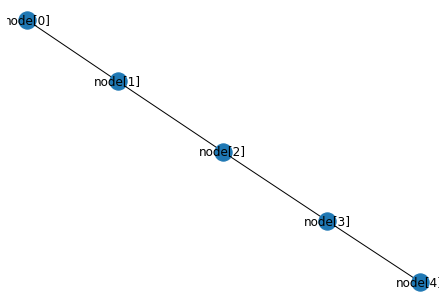

In [6]:
santiago_graph = nx.Graph(pytket_santiago_device.coupling)
nx.draw(santiago_graph, labels = {node:node for node in santiago_graph.nodes()})

SPAM correction requires subsets of qubits which are assumed to only have SPAM errors correlated with each other, and no other qubits. <br>
Correlated errors are usually dependent on the connectivity layout of devices, as shown above. <br>
As Santiago is a small 5-qubit device with few connections, let's assume that all qubits have correlated SPAM errors. The number of calibration circuits produced is exponential in the maximum number of correlated circuits, so finding good subsets of correlated qubits is important for characterising larger devices with smaller experimental overhead.

We get a noise model from ```ibmq_santiago``` using qiskit-aer, make a simulator backend, and then execute all calibration circuits through the backend.

In [7]:
from pytket.extensions.qiskit import AerBackend
from qiskit.providers.aer.noise import NoiseModel

n_shots = 8192 
santiago_node_subsets = pytket_santiago_device.nodes
pytket_noisy_sim_backend = AerBackend(NoiseModel.from_backend(ibmq_santiago_backend))
santiago_spam = SpamCorrecter([santiago_node_subsets], pytket_noisy_sim_backend)

The SpamCorrecter uses these subsets of qubits to produce calibration circuits.

In [8]:
calibration_circuits = santiago_spam.calibration_circuits()
print('Number of calibration circuits: ' , len(calibration_circuits))

Number of calibration circuits:  32


In [9]:
sim_handles = pytket_noisy_sim_backend.process_circuits(calibration_circuits, n_shots)

Count results from the simulator are then used to calculate the matrices used for SPAM correction for ```ibmq_santiago```.

In [10]:
sim_count_results = (pytket_noisy_sim_backend.get_result(handle).get_counts() for handle in sim_handles)
santiago_spam.calculate_matrices(sim_count_results)

In [11]:
from pytket import Circuit

ghz_circuit = Circuit(len(pytket_santiago_device.nodes)).H(0).CX(0,1).CX(1,2).measure_all()
pytket_noisy_sim_backend.compile_circuit(ghz_circuit)
ghz_noisy_counts = pytket_noisy_sim_backend.get_counts(ghz_circuit,n_shots)

We also run a noiseless simulation so we can compare performance.

In [12]:
pytket_noiseless_sim_backend = AerBackend()
ghz_noiseless_counts = pytket_noiseless_sim_backend.get_counts(ghz_circuit,n_shots)

Noisy simulator counts are corrected using the ```SpamCorrecter``` objects ```correct_counts``` method.<br>
To correctly amend counts, the ```correct_counts``` method requires the executed circuits qubit_readout, a map from qubit to its index in readouts from backends.

In [13]:
ghz_spam_corrected_counts = santiago_spam.correct_counts(ghz_noisy_counts, ghz_circuit.qubit_readout)

Import and define the Jensen-Shannon divergence, which we will use for comparing performance. The Jensen-Shannon divergence is a symmetric and finite measure of similarity between two probability distributions. A smaller divergence implies more similarity between two probability distributions.

In [14]:
from scipy.stats import entropy
import numpy as np
import itertools

In [15]:
def binseq(k):
    return [''.join(x) for x in itertools.product('01', repeat=k)]

def probs_from_counts(counts):
    counts_dict = dict()
    for x in counts:
        counts_dict[''.join(str(e) for e in x)]=counts[x]
    converted = []
    binary_strings = binseq(len(list(counts.keys())[0]))
    for b in binary_strings:
        converted.append(counts_dict.get(b,0))
    return converted / np.sum(converted)

def JSD(P, Q):
    _P = P / np.linalg.norm(P, ord=1)
    _Q = Q / np.linalg.norm(Q, ord=1)
    _M = 0.5 * (_P + _Q)
    return 0.5 * (entropy(_P, _M) + entropy(_Q, _M))

Convert our counts results to a probability distribution over the basis states for comparison. 

In [16]:
ghz_noiseless_probabilities = probs_from_counts(ghz_noiseless_counts)
ghz_noisy_probabilities = probs_from_counts(ghz_noisy_counts)
ghz_spam_corrected_probabilities = probs_from_counts(ghz_spam_corrected_counts)

In [17]:
print('Jensen-Shannon Divergence between noiseless simulation probability distribution and noisy simulation probability distribution: ',
      JSD(ghz_noiseless_probabilities, ghz_noisy_probabilities))
print('Jensen-Shannon Divergence between noiseless simulation probability distribution and spam corrected noisy simulation probability distribution: ', 
      JSD(ghz_noiseless_probabilities, ghz_spam_corrected_probabilities))

Jensen-Shannon Divergence between noiseless simulation probability distribution and noisy simulation probability distribution:  0.030124006310110682
Jensen-Shannon Divergence between noiseless simulation probability distribution and spam corrected noisy simulation probability distribution:  0.005148185743496127


In our noisy simulated case, spam corrected results produced a distribution closer to the expected distribution. <br>
There are two methods available for correcting counts: the default ```bayesian```, and ```invert```. Further information on each method is available at our [documentation](https://cqcl.github.io/pytket/build/html/utils.html#module-pytket.utils.spam).<br>
Let's look at how the ```invert``` method performs.

In [18]:
ghz_invert_corrected_counts = santiago_spam.correct_counts(ghz_noisy_counts, ghz_circuit.qubit_readout, method = 'invert')
ghz_invert_probabilities = probs_from_counts(ghz_invert_corrected_counts)

print('Jensen-Shannon Divergence between noiseless simulation probability distribution and Bayesian-corrected noisy simulation probability distribution: ', 
      JSD(ghz_noiseless_probabilities, ghz_spam_corrected_probabilities))
print('Jensen-Shannon Divergence between noiseless simulation probability distribution and invert-corrected noisy simulation probability distribution: ', 
      JSD(ghz_noiseless_probabilities, ghz_invert_probabilities))

Jensen-Shannon Divergence between noiseless simulation probability distribution and Bayesian-corrected noisy simulation probability distribution:  0.005148185743496127
Jensen-Shannon Divergence between noiseless simulation probability distribution and invert-corrected noisy simulation probability distribution:  0.0048690261389994


Lets change from our simulator backend to the Santiago IBMQ device to see how SPAM correction performs on real results.

In [19]:
from pytket.extensions.qiskit import IBMQBackend
ibm_backend = IBMQBackend('ibmq_santiago')

In [20]:
santiago_spam_real = SpamCorrecter([ibm_backend.device.nodes], ibm_backend)
ibm_backend.compile_circuit(ghz_circuit)
all_circuits = santiago_spam_real.calibration_circuits() + [ghz_circuit]
ibm_handles = ibm_backend.process_circuits(all_circuits, n_shots)

In [22]:
ibm_calibration_results = (ibm_backend.get_result(handle).get_counts() for handle in ibm_handles[:-1])
santiago_spam_real.calculate_matrices(ibm_calibration_results)

Job Status: job has successfully run


In [23]:
ghz_santiago_counts = ibm_backend.get_result(ibm_handles[-1]).get_counts()
ghz_santiago_probabilities = probs_from_counts(ghz_santiago_counts)

Finally we compare performance for our machine results:

In [24]:
ghz_spam_corrected_santiago_counts = santiago_spam_real.correct_counts(ghz_santiago_counts, ghz_circuit.qubit_readout)
ghz_invert_corrected_counts = santiago_spam_real.correct_counts(ghz_santiago_counts, ghz_circuit.qubit_readout, method = 'invert')

ghz_spam_corrected_santiago_probabilities = probs_from_counts(ghz_spam_corrected_counts)
ghz_invert_probabilities = probs_from_counts(ghz_invert_corrected_counts)

print('Jensen-Shannon Divergence between noiseless simulation probability distribution and santiago probability distribution: ', 
      JSD(ghz_noiseless_probabilities, ghz_santiago_probabilities))
print('Jensen-Shannon Divergence between noiseless simulation probability distribution and Bayesian-corrected santiago probability distribution: ', 
      JSD(ghz_noiseless_probabilities, ghz_spam_corrected_santiago_probabilities))
print('Jensen-Shannon Divergence between noiseless simulation probability distribution and invert-corrected santiago probability distribution: ', 
      JSD(ghz_noiseless_probabilities, ghz_invert_probabilities))

Jensen-Shannon Divergence between noiseless simulation probability distribution and santiago probability distribution:  0.0927898369011113
Jensen-Shannon Divergence between noiseless simulation probability distribution and Bayesian-corrected santiago probability distribution:  0.004773018844253832
Jensen-Shannon Divergence between noiseless simulation probability distribution and invert-corrected santiago probability distribution:  0.04090501183039972
